## PCA/NMF demos

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

Mike Gelbart

In [1]:
import numpy as np
import pickle
import os.path
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA, NMF, MiniBatchSparsePCA
from sklearn.manifold import TSNE

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
# helper functions
def display_face(f, cmap='Greys_r', vmin=None, vmax=None):
    plt.imshow(np.reshape(f, (32,32)).T, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.tick_params(axis='both', which='both', 
                    bottom=False, left=False, 
                    labelbottom=False, labelleft=False)
    plt.grid(False)    
def reconstruct(model, X):
    Z = model.transform(X)
    try:
        return model.inverse_transform(Z)
    except AttributeError: # no inverse_transform function
        W = model.components_
        return Z@W
    # Note on the above: you can't just do Z@W for PCA because of the centring of the data, 
    # which needs to be undone for the reconstruction

In [4]:
with open(os.path.join("img","faces.pkl"), "rb") as f:
    faces = pickle.load(f)

n,d = faces.shape
print("We have %d faces, each 32x32 pixels." % n)

We have 2414 faces, each 32x32 pixels.


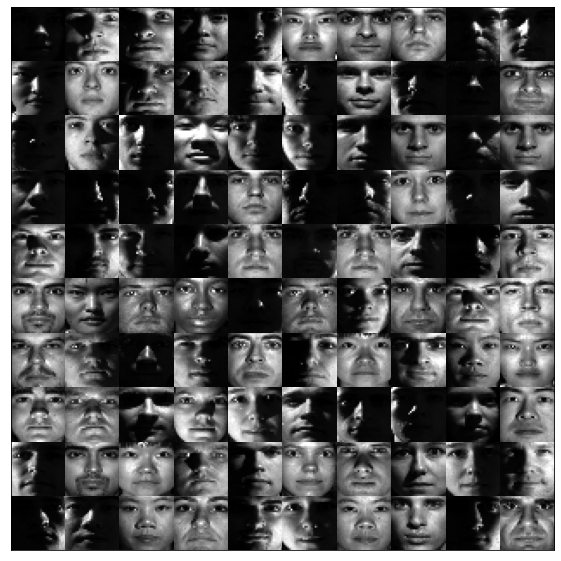

In [5]:
plt.figure(figsize=(10,10))
numx = 10
numy = 10
for i in range(numx):
    for j in range(numy):
        face = np.reshape(faces[np.random.randint(0,n)], (32,32)).T
        plt.imshow(face, extent=(i*32,(i+1)*32,j*32,(j+1)*32), cmap="gray")
plt.xlim((0,numx*32))
plt.ylim((0,numy*32))
plt.xticks([]);
plt.yticks([]);

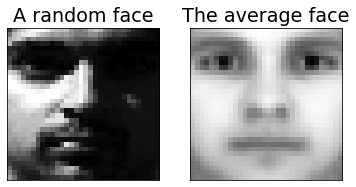

In [6]:
plt.figure()
plt.subplot(1,2,1)
display_face(random.choice(faces))
plt.title("A random face")
plt.subplot(1,2,2)
display_face(np.mean(faces,axis=0))
plt.title("The average face");

## Finding eigenfaces with scikit-learn's PCA

In [7]:
pca = PCA()
pca.fit(faces);

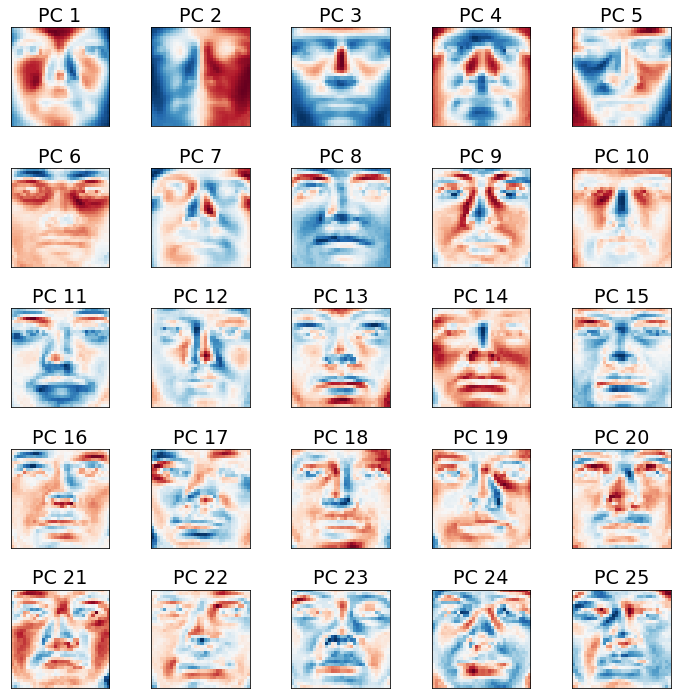

In [8]:
# show components
plt.figure(figsize=(10,10))
numx = 5
numy = 5
for i in range(numx):
    for j in range(numy):
        ind = i*numy+j
        plt.subplot(numx,numy,ind+1)
        face = np.reshape(pca.components_[ind], (32,32)).T
        plt.imshow(face, cmap="RdBu_r", origin="upper")
        plt.xticks([]);
        plt.yticks([]);
        plt.title("PC %d" % (ind+1));
plt.tight_layout();

Above: these are "signed" images (blue is negative, red is positive?).

### Plotting the $Z$ when $k=2$

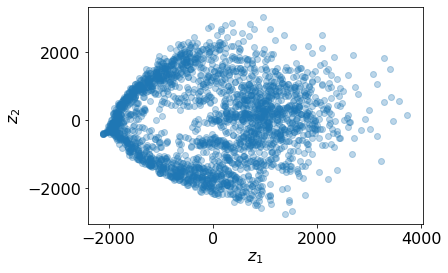

In [9]:
Z = PCA(n_components=2).fit_transform(faces)
plt.scatter(Z[:,0], Z[:,1], alpha=0.3);
plt.xlabel('$z_1$');
plt.ylabel('$z_2$');

Picking a few representative examples from this scatterplot...

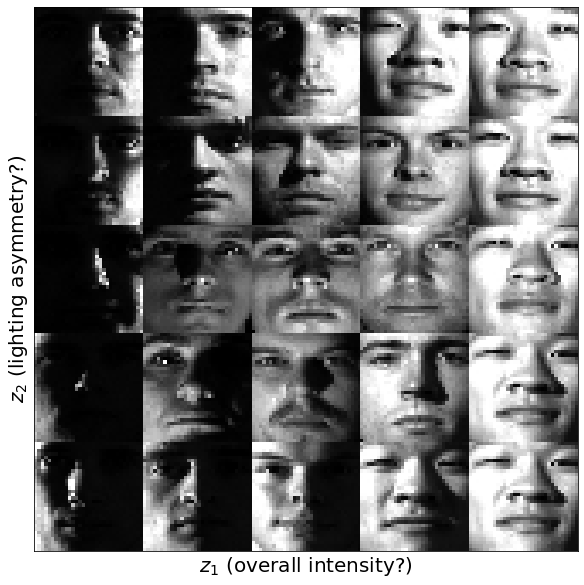

In [10]:
def index_of_closest_face_to_point(point):
    return np.argmin( np.sum((Z-point)**2,axis=1) )

plt.figure(figsize=(10,10))
for i,x in enumerate(np.linspace(np.min(Z[:,0]),np.max(Z[:,0]),5)):
    for j,y in enumerate(np.linspace(np.min(Z[:,1]),np.max(Z[:,1]),5)):
        idx = index_of_closest_face_to_point([x,y])
        face = np.reshape(faces[idx], (32,32)).T
        plt.imshow(face, extent=(i*32,(i+1)*32,j*32,(j+1)*32), cmap='gray')
plt.xlim((0,160))
plt.ylim((0,160))
plt.xticks([])
plt.yticks([])
plt.xlabel("$z_1$ (overall intensity?)", fontsize=20)
plt.ylabel("$z_2$ (lighting asymmetry?)", fontsize=20)
plt.show()

### Variance explained?

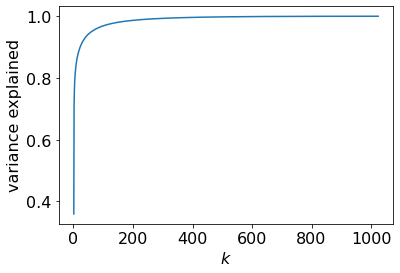

In [11]:
plt.plot(np.arange(1,faces.shape[1]+1), np.cumsum(pca.explained_variance_ratio_));
plt.xlabel("$k$");
plt.ylabel("variance explained");

### (Optional) "from scratch" implementation with SVD

In [12]:
pixel_means = np.mean(faces,axis=0)
faces_centered = faces - pixel_means
u,s,W = np.linalg.svd(faces_centered, full_matrices=False)
Z = u@np.diag(s)

In [13]:
for i in range(1,6):
    reconstr = Z[:,:i]@W[:i]
    var_expl = 1-np.sum((reconstr-faces_centered)**2)/np.sum(faces_centered**2)
    print("With %2d components, variance explained = %.0f%%" % (i, var_expl*100))

With  1 components, variance explained = 36%
With  2 components, variance explained = 71%
With  3 components, variance explained = 76%
With  4 components, variance explained = 79%
With  5 components, variance explained = 80%


## Sparse matrix factorization

Fitting PCA
Fitting NMF


/Users/dyyylan/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/dyyylan/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Fitting Sparse PCA


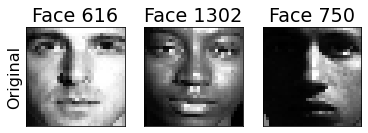

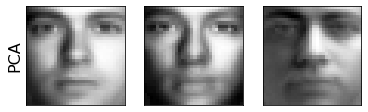

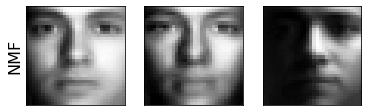

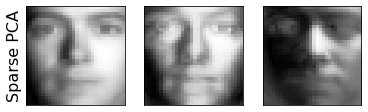

In [18]:
k = 10

models = {
    "PCA": PCA(n_components=k), 
    "NMF": NMF(n_components=k), 
    "Sparse PCA": MiniBatchSparsePCA(n_components=k, alpha=50)}

np.random.seed(10)
inds = np.random.choice(n, size=3, replace=False) # pick 3 images at random to display

plt.figure()

# Plot the original faces
for counter, i in enumerate(inds):
    plt.subplot(1,len(inds),counter+1)
    display_face(faces[i])
    if counter==0:
        plt.ylabel("Original")
    plt.title("Face %d" % i)

# For each method, fit it and then plot the reconstructed faces        
for method_name, model in models.items():
    print("Fitting %s" % method_name)
    model.fit(faces)

    reconstructions = reconstruct(model, faces)

    plt.figure()
    for counter, i in enumerate(inds):
        plt.subplot(1,len(inds),counter+1)
        display_face(reconstructions[i])
        if counter==0:
            plt.ylabel(method_name)

(can try some different values of $k$)

The reconstructions look similar, but what about the components?

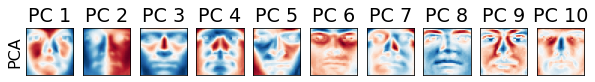

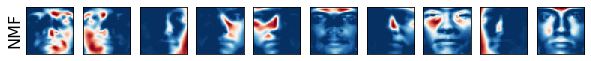

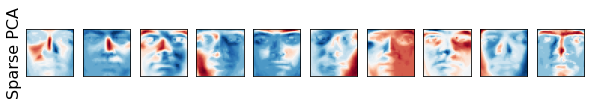

In [19]:
method_count = 0
for method_name, model in models.items():
    plt.figure(figsize=(10,10))
    for i in range(k):
        plt.subplot(1,k,i+1)
        display_face(model.components_[i], cmap='RdBu_r')
        if method_count == 0:
            plt.title("PC %d" % (i+1))
        if i == 0:
            plt.ylabel(method_name)
    method_count += 1

In [ ]:
m = models["NMF"]
np.alltrue(m.components_>=0)

We can compute the sparsity of $Z$ and $W$:

In [20]:
for method_name, model in models.items():
    print(method_name)
    Z = model.transform(faces)
    W = model.components_
    
    reconstructions = reconstruct(model, faces)
    
    print("  avg reconstruction error: %f" % np.mean((faces-reconstructions)**2))
    print("  sparsity of Z: %.2f (fraction of zeros)" % np.mean(np.abs(Z)<1e-8))
    print("  sparsity of W: %.2f (fraction of zeros)" % np.mean(np.abs(W)<1e-8))
    print()

PCA
  avg reconstruction error: 551.281545
  sparsity of Z: 0.00 (fraction of zeros)
  sparsity of W: 0.00 (fraction of zeros)

NMF
  avg reconstruction error: 597.578398
  sparsity of Z: 0.25 (fraction of zeros)
  sparsity of W: 0.34 (fraction of zeros)

Sparse PCA
  avg reconstruction error: 5605.067219
  sparsity of Z: 0.00 (fraction of zeros)
  sparsity of W: 0.19 (fraction of zeros)



Given the above, what sort of regularization do you think the scikit-learn sparse PCA is using for $Z$ and $W$? 

If you're curious, see [here](https://github.com/scikit-learn/scikit-learn/blob/bac89c253b35a8f1a3827389fbee0f5bebcbc985/sklearn/decomposition/dict_learning.py#L429-L431), though it's not immediately clear that $V$ is $Z$ and $U$ is $W$ unless you look [here](https://github.com/scikit-learn/scikit-learn/blob/bac89c253b35a8f1a3827389fbee0f5bebcbc985/sklearn/decomposition/dict_learning.py#L498-L504) and [here](https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/decomposition/sparse_pca.py#L178-L189) to see that they are swapped.

### Orthogonality

We can see that the components are normalized and orthogonal for PCA only.

In [21]:
i, j = np.random.choice(k, size=2, replace=False)

for method_name, model in models.items():
    print(method_name)
    W = model.components_
    print("  ||w_i||^2 =", W[i]@W[i])
    print("  ||w_j||^2 =", W[j]@W[j])
    print("  <w_i,w_j> =", W[i]@W[j])

PCA
  ||w_i||^2 = 0.9999999999999991
  ||w_j||^2 = 1.0
  <w_i,w_j> = -9.71445146547012e-17
NMF
  ||w_i||^2 = 51137.785987825475
  ||w_j||^2 = 70051.25489958999
  <w_i,w_j> = 21957.012841174714
Sparse PCA
  ||w_i||^2 = 0.999999999999999
  ||w_j||^2 = 0.9999999999999997
  <w_i,w_j> = 0.10240373551388927
